In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from models.enums.chartType import TrainingCharts
from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil

In [99]:
dataset = XOR()
in_features = 6
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True, split_percent=0.8)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [100]:
len(X_train), len(X_val)

(51, 13)

In [101]:
import numpy as np

def validate_input(X_train, X_val):
    datasetValidation = np.zeros((11))
    for i in [i.sum() for i in X_train]:
        datasetValidation[int(i.item())]+=1
    print(datasetValidation)

    datasetValidation = np.zeros((11))
    for i in [i.sum() for i in X_val]:
        datasetValidation[int(i.item())]+=1
    print(datasetValidation)

In [102]:
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [ ]:
layers = 3
model_params_all = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (200, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 10), "l2": (200, 10), "l3": (200, None)}
model_params_first_third = {"l1": (200, 10), "l2": (200, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (200, 10), "l3": (200, 10)}

In [125]:
def get_models_to_plot_from_combined(combined_charts):
    sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i]
    control_models = [ i for i in combined_charts.get_models() if "Control" in i]
    dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]

    return sparse_models, control_models, dense_models

In [126]:
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second,
               "3rd L Sparse": model_params_third,
               "1st and 2nd L Sparse": model_params_first_second,
               "1st and 3rd L Sparse": model_params_first_third,
               "2nd and 3rd L Sparse": model_params_second_third
            }

In [127]:
chartUtils_6D = {}
chartUtils_6D["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs=150,
    n_runs = 20,
    batch_train= True
)

for modelName in model_types:
    chartUtils_6D[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 150,
        n_runs = 20,
        batch_train= True
        )

In [128]:
model_keys = list(chartUtils_6D.keys())
combined_charts: ChartUtil = chartUtils_6D[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_6D[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3681050318.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3681050318.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3681050318.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3681050318.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


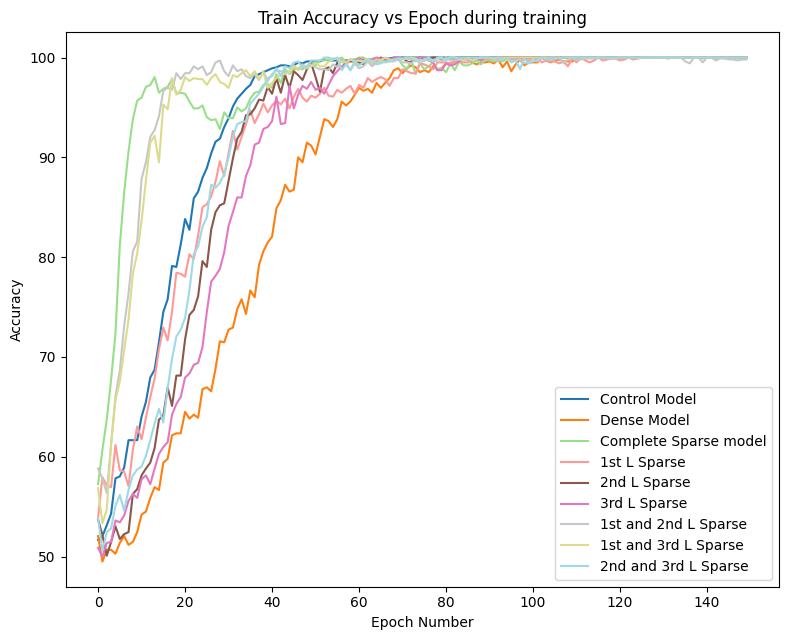

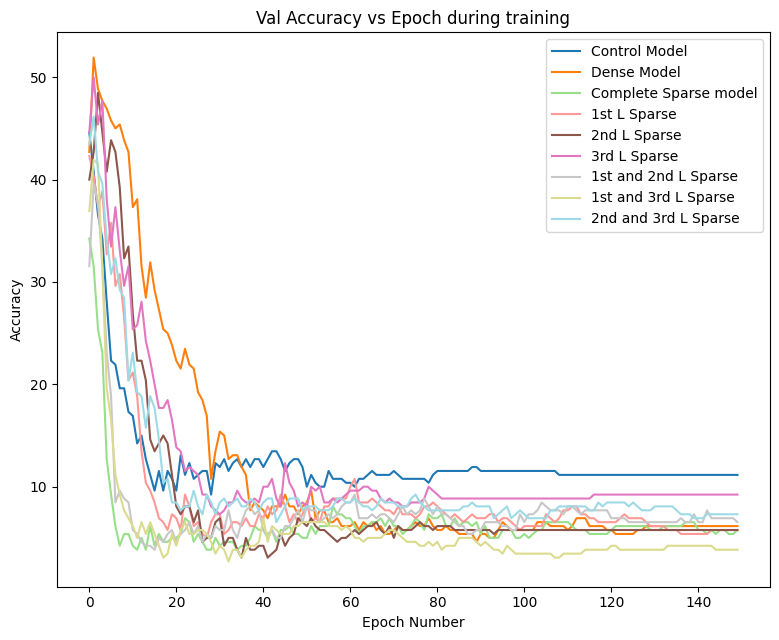

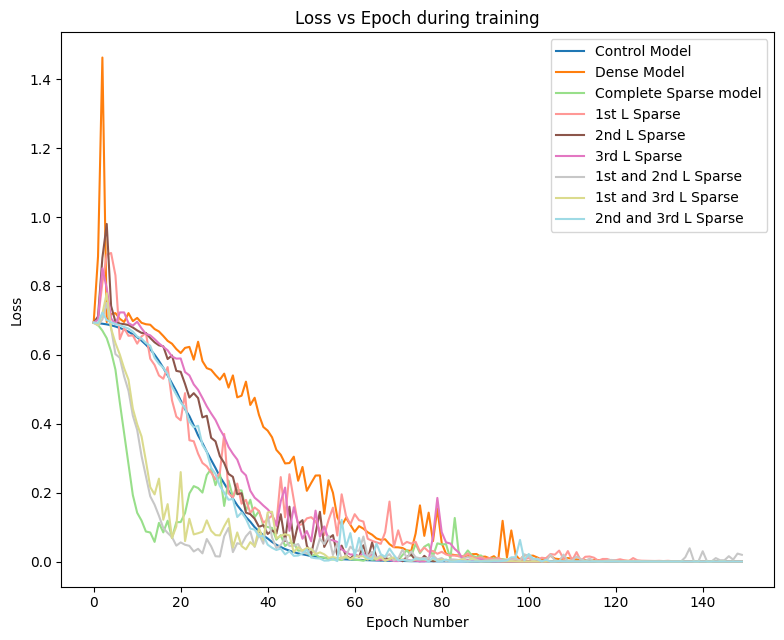

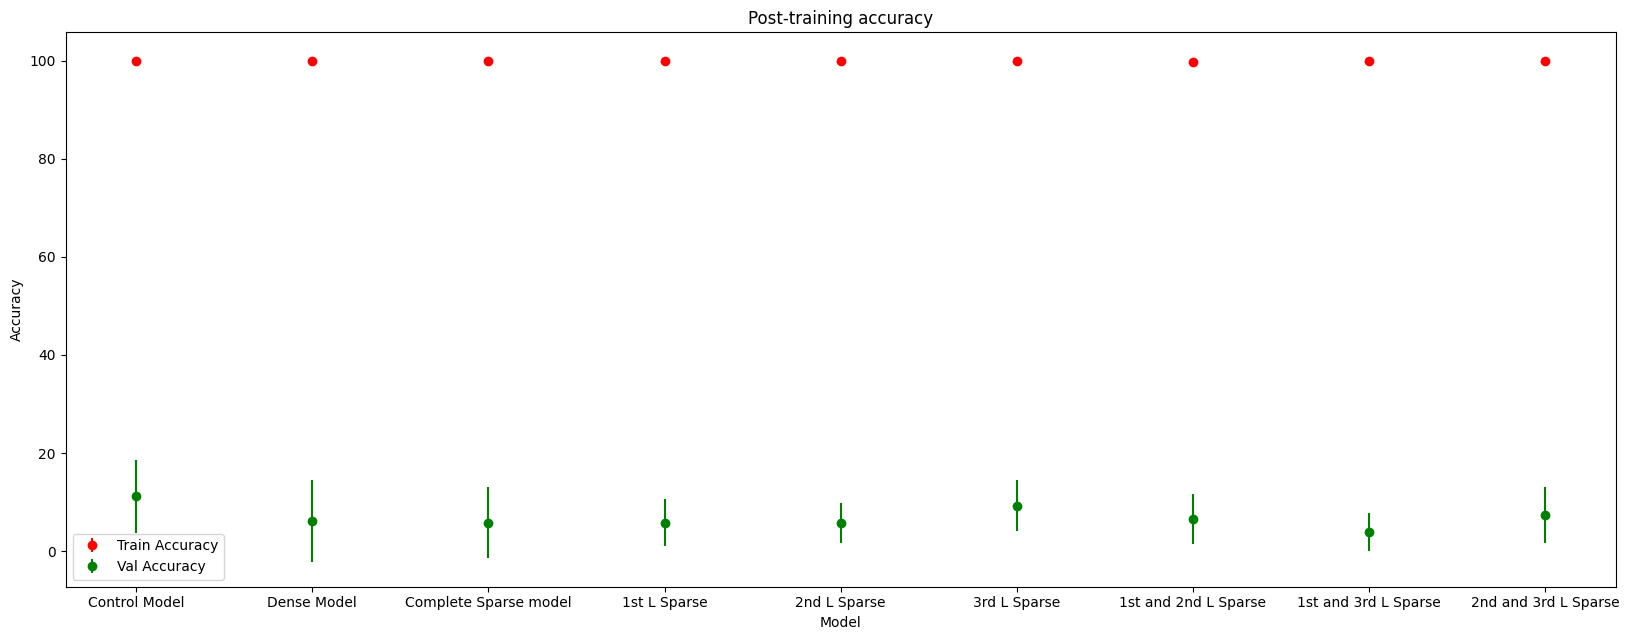

In [129]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    # models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    # models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    no_std = True,
    # models = sparse_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    # models = sparse_models   
    ).show()

In [82]:
dataset = XOR()
in_features = 8
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [83]:
validate_input(X_train, X_val)
len(X_train), len(X_val)

[ 1.  7. 25. 41. 53. 49. 21.  6.  1.  0.  0.]
[ 0.  1.  3. 15. 17.  7.  7.  2.  0.  0.  0.]


(204, 52)

In [84]:
chartUtils_8D = {}
chartUtils_8D["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs = 150,
    n_runs=20,
    batch_train= True
)

for modelName in model_types:
    chartUtils_8D[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 150,
        n_runs = 20,
        batch_train= True
        )

In [88]:
model_keys = list(chartUtils_8D.keys())
combined_charts: ChartUtil = chartUtils_8D[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_8D[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3690377020.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3690377020.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3690377020.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_30962/3690377020.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


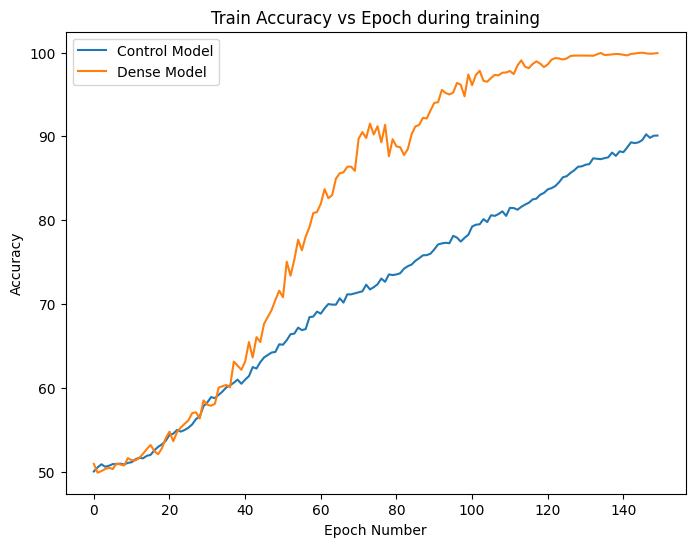

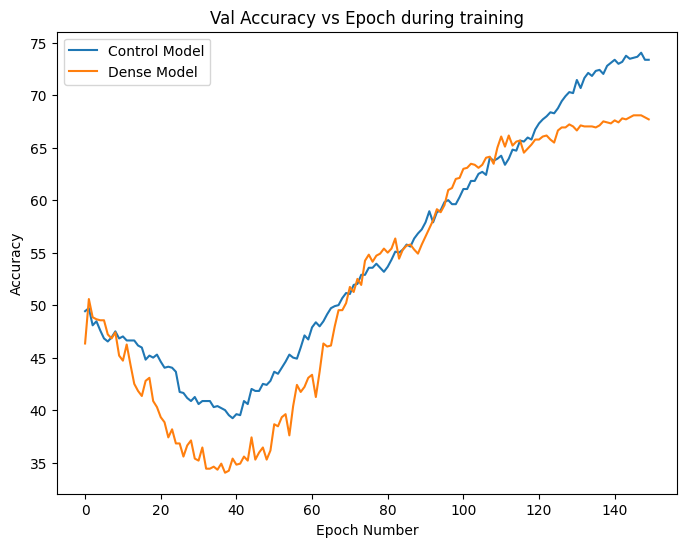

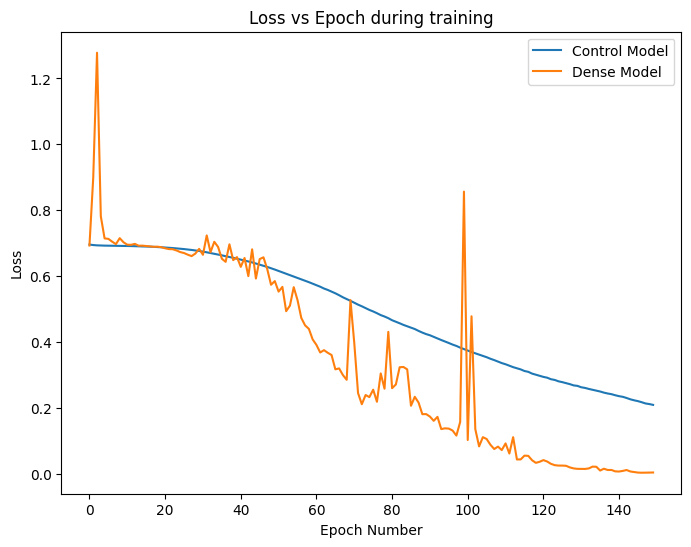

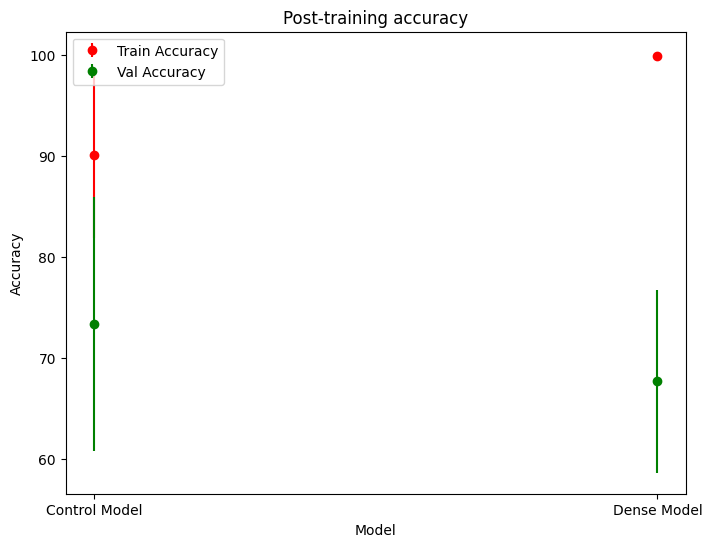

In [91]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    models = control_models + dense_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    models = control_models + dense_models   
    ).show()
combined_charts.plot_training_data_for(
    no_std = True,
    models = control_models + dense_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    models = control_models + dense_models   
    ).show()

In [13]:
dataset = XOR()
in_features = 10
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)
validate_input(X_train, X_val)

[  1.   8.  35.  97. 178. 204. 162.  91.  33.   9.   1.]
[ 0.  2. 10. 23. 32. 48. 48. 29. 12.  1.  0.]


In [14]:
chartUtils_10D = {}
chartUtils_10D["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs=400,
    batch_train= True,
    n_runs = 20
)

for modelName in model_types:
    print("Starting", modelName)
    chartUtils_10D[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 400,
        batch_train= True,
        n_runs = 20
        )
    print("Ending", modelName)

Starting Complete Sparse model
Ending Complete Sparse model
Starting 1st L Sparse
Ending 1st L Sparse
Starting 2nd L Sparse
Ending 2nd L Sparse
Starting 3rd L Sparse
Ending 3rd L Sparse
Starting 1st and 2nd L Sparse
Ending 1st and 2nd L Sparse
Starting 1st and 3rd L Sparse
Ending 1st and 3rd L Sparse
Starting 2nd and 3rd L Sparse
Ending 2nd and 3rd L Sparse


In [15]:
model_keys = list(chartUtils_10D.keys())
combined_charts: ChartUtil = chartUtils_10D[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_10D[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


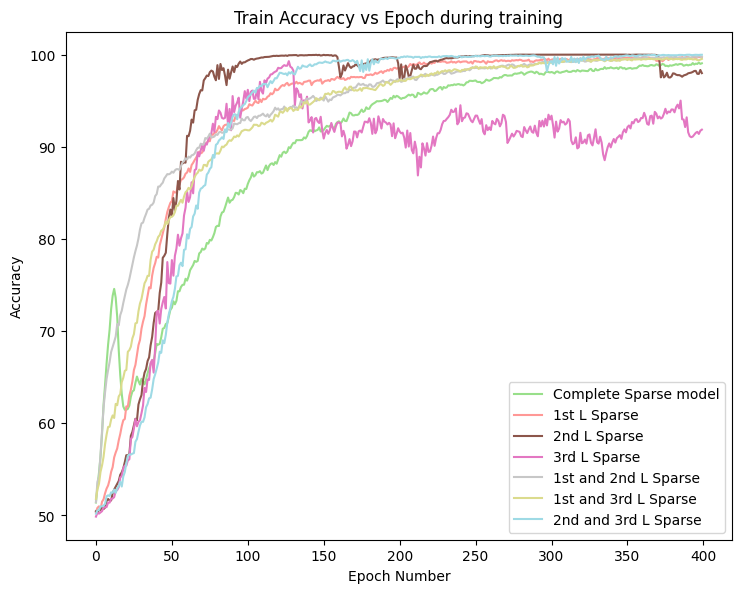

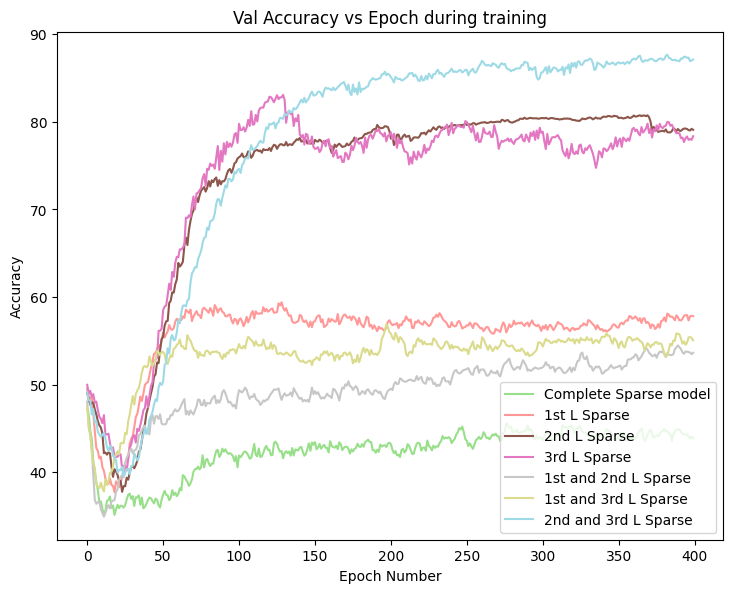

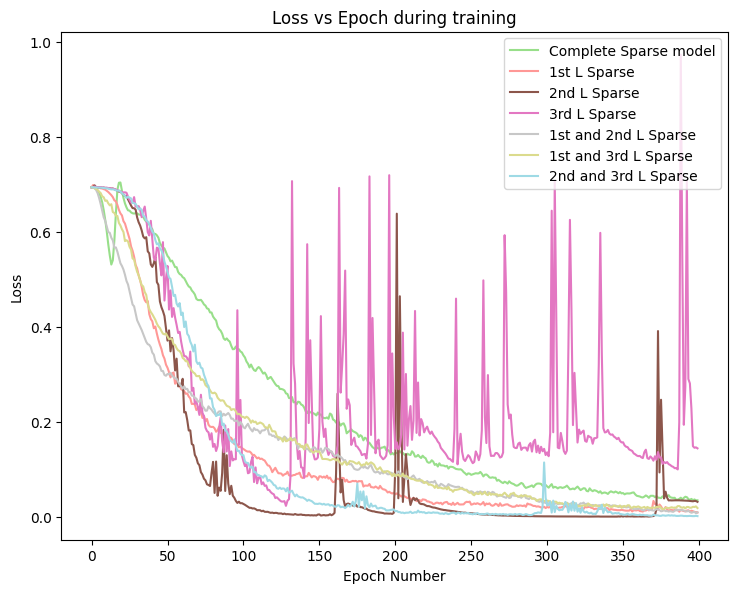

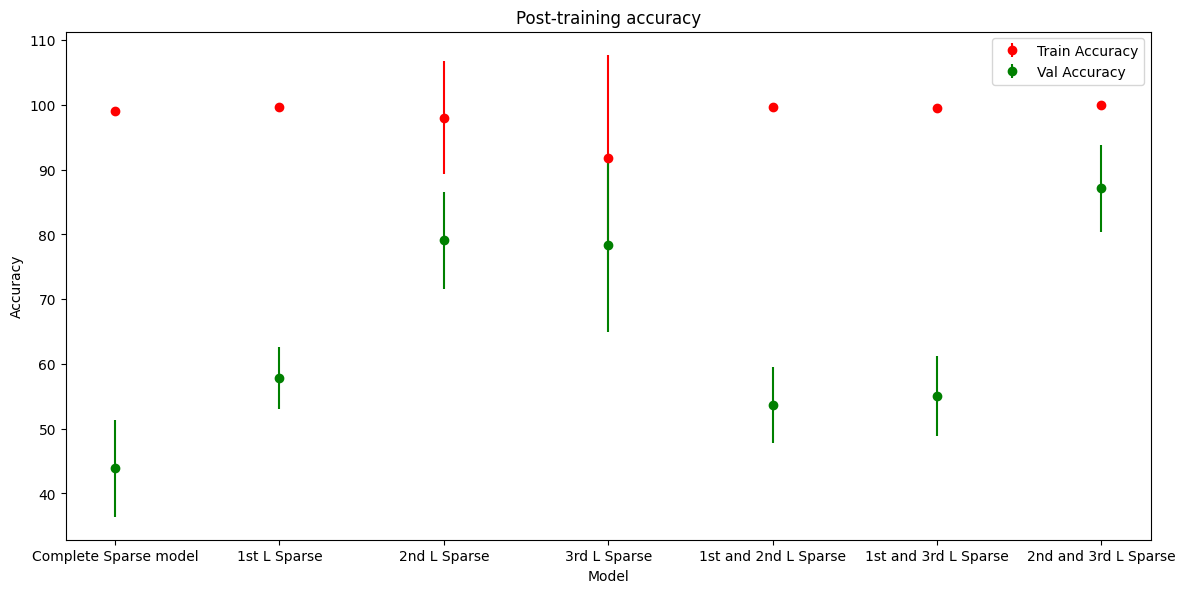

In [18]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(no_std = True,
                                      models = sparse_models
                                       ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    models = sparse_models
    ).show()